<a href="https://colab.research.google.com/github/ezeiberg33/spinSynthFinal/blob/main/MidtermCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install monai nibabel numpy scipy matplotlib tqdm SimpleITK
!pip install neuroHarmonize nilearn tqdm
!pip install neuroHarmonize neuroCombat

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 100.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neuroCombat: filename=neuroCombat-0.2.12-py3-none-any.whl size=6353 sha256=1bce55a3187bd52e83142b6c8763d0093c9b7562c1dd9ddcdef6fc56d155ccfa
  Stored in directory: /root/.cache/pip/wheels/be/6a/95/9d827c0f3cc23854b5fbd00fbc8a052d492538dc16bd20f7a2
Successfully built neuroCombat


In [ ]:
import torch
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
from nilearn import datasets, image, masking
from tqdm import tqdm
from neuroHarmonize import harmonizationLearn
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Finding patients that have T1 and T2 scans

In [ ]:
t1_dir = "/content/drive/MyDrive/T1T2Data/IXI-T1"           # Folder with T1 images
t2_dir = "/content/drive/MyDrive/T1T2Data/IXI-T2"           # Folder with corresponding T2 images

# Get sorted lists of filenames
t1_files = sorted([f for f in os.listdir(t1_dir) if f.endswith(('.nii', '.nii.gz'))])
t2_files = sorted([f for f in os.listdir(t2_dir) if f.endswith(('.nii', '.nii.gz'))])

t1_files_stripped = [f.split('.')[0][0:-3] for f in t1_files]
t2_files_stripped = [f.split('.')[0][0:-3] for f in t2_files]

t1Set = set(t1_files_stripped)
t2Set = set(t2_files_stripped)

# Find the intersection of sets
shared_images = t1Set & t2Set

# Remove files that aren't in T1 and T2
t1_files_shared= [f for f in t1_files if f.split('.')[0][0:-3] in shared_images]
t2_files_shared= [f for f in t2_files if f.split('.')[0][0:-3] in shared_images]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/T1T2Data/IXI-T1'

# Aligning Pairs

This code was used to register the original T1 and T2 scans so that they follow the same coordinate system (RAS), have consistent slice indices, and align the images so the same features are in the same location (i.e. correct for patient movement). The registered images were saved, and the original files were deleted in order to preserve space.

In [ ]:
import os
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Configuration
t1_dir = "/content/drive/MyDrive/T1T2Data/IXI-T1"           # Folder with T1 images
t2_dir = "/content/drive/MyDrive/T1T2Data/IXI-T2"           # Folder with corresponding T2 images

output_dir = "data/registered"  # Where to save aligned T2 outputs
save_path_T1 = "/content/drive/MyDrive/T1T2Data/Registrered/T1"
save_path_T2 = "/content/drive/MyDrive/T1T2Data/Registrered/T2"
visualize = False             # Set False to disable matplotlib display

os.makedirs(output_dir, exist_ok=True)
os.makedirs(save_path_T1, exist_ok=True)
os.makedirs(save_path_T2, exist_ok=True)


t1_files_shared_shortened = t1_files_shared #[:10]
t2_files_shared_shortened = t2_files_shared #[:10]

# Registration
for idx, (t1_file, t2_file) in enumerate(zip(t1_files_shared_shortened, t2_files_shared_shortened)):
    print(f"\n=== Processing pair {idx+1}/{len(t1_files_shared_shortened)} ===")
    print(f"T1: {t1_file}")
    print(f"T2: {t2_file}")

    t1_path = os.path.join(t1_dir, t1_file)
    t2_path = os.path.join(t2_dir, t2_file)

    if not os.path.exists(os.path.join(save_path_T1,os.path.splitext(os.path.splitext(t1_file)[0])[0] + ".nii.gz")):

      # Load and reorient to canonical
      t1_nib = nib.load(t1_path)
      t2_nib = nib.load(t2_path)
      t1_canon = nib.as_closest_canonical(t1_nib)
      t2_canon = nib.as_closest_canonical(t2_nib)

      # Save temporary canonical versions
      t1_tmp = "t1_canonical_tmp.nii.gz"
      t2_tmp = "t2_canonical_tmp.nii.gz"
      nib.save(t1_canon, t1_tmp)
      nib.save(t2_canon, t2_tmp)

      #Load with SimpleITK
      fixed = sitk.ReadImage(t1_tmp, sitk.sitkFloat32)
      moving = sitk.ReadImage(t2_tmp, sitk.sitkFloat32)

      #Initialize transform
      initial_transform = sitk.CenteredTransformInitializer(
          fixed,
          moving,
          sitk.AffineTransform(3),
          sitk.CenteredTransformInitializerFilter.GEOMETRY
      )

      #Registration setup
      registration_method = sitk.ImageRegistrationMethod()
      registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
      registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
      registration_method.SetMetricSamplingPercentage(0.2)
      registration_method.SetInterpolator(sitk.sitkLinear)
      registration_method.SetOptimizerAsGradientDescent(
          learningRate=1.0,
          numberOfIterations=200,
          estimateLearningRate=registration_method.Once
      )
      registration_method.SetOptimizerScalesFromPhysicalShift()
      registration_method.SetInitialTransform(initial_transform, inPlace=False)

      #Run registration
      final_transform = registration_method.Execute(fixed, moving)

      #Apply transform (resample)
      resampled_moving = sitk.Resample(
          moving,
          fixed,
          final_transform,
          sitk.sitkLinear,
          0.0,
          moving.GetPixelID()
      )

      # Convert SimpleITK images back to nibabel images
      fixed_nib = nib.Nifti1Image(sitk.GetArrayFromImage(fixed), affine=t1_canon.affine)
      resampled_moving_nib = nib.Nifti1Image(sitk.GetArrayFromImage(resampled_moving), affine=t1_canon.affine)


      #Save output
      out_name = os.path.splitext(os.path.splitext(t1_file)[0])[0] + ".nii.gz"
      nib.save(fixed_nib, os.path.join(save_path_T1, out_name))

      out_name = os.path.splitext(os.path.splitext(t2_file)[0])[0] + ".nii.gz"
      nib.save(resampled_moving_nib, os.path.join(save_path_T2, out_name))

      #Visualization
      if visualize:
          fixed_np = sitk.GetArrayFromImage(fixed)
          resampled_np = sitk.GetArrayFromImage(resampled_moving)
          slice_idx = fixed_np.shape[0] // 2

          plt.figure(figsize=(8, 4))
          plt.subplot(1, 2, 1)
          plt.imshow(fixed_np[slice_idx], cmap='gray')
          plt.title("T1 (Fixed)")
          plt.axis('off')

          plt.subplot(1, 2, 2)
          plt.imshow(resampled_np[slice_idx], cmap='gray')
          plt.title("T2 (Registered)")
          plt.axis('off')
          plt.suptitle(f"Pair {idx+1}: {t1_file}")
          plt.show()
    elif os.path.exists(t1_path) and os.path.exists(t2_path):
      os.remove(t1_path)
      os.remove(t2_path)
      print("deleted original files")

print("\nAll pairs processed successfully!")

# Combat Harmonization

In [ ]:
rng = np.random.default_rng()
t1_dir = "/content/drive/MyDrive/T1T2Data/Registered/T1"
t2_dir = "/content/drive/MyDrive/T1T2Data/Registered/T2"


t1_files = sorted([f for f in os.listdir(t1_dir) if f.endswith(('.nii', '.nii.gz'))])
t1_full_names=[]
for f in t1_files:
  f_full_name = os.path.join(t1_dir, f)
  t1_full_names.append(f_full_name)

t2_files = sorted([f for f in os.listdir(t2_dir) if f.endswith(('.nii', '.nii.gz'))])
t2_full_names=[]
for f in t2_files:
  f_full_name = os.path.join(t2_dir, f)
  t2_full_names.append(f_full_name)

meta_path = "IXI.xls"
meta_data = pd.read_excel(meta_path)

In [ ]:
ids = [int(f.split('-')[0][-3:]) for f in t1_full_names]
used_patiets_meta = meta_data.loc[meta_data['IXI_ID'].isin(ids)]
used_patiets_meta=used_patiets_meta.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=False, ignore_index=False)
t1_full_names_keep = []
t2_full_names_keep = []
ids_keep = []
for i in ids:
  if i in used_patiets_meta["IXI_ID"].values:
    ids_keep.append(i)

for f in t1_full_names:
  f_id = int(f.split('-')[0][-3:])
  if f_id in ids_keep:
      t1_full_names_keep.append(f)

for f in t2_full_names:
  f_id = int(f.split('-')[0][-3:])
  if f_id in ids_keep:
      t2_full_names_keep.append(f)
locations = [f.split('-')[1] for f in t1_full_names_keep]
used_patiets_meta['SITE'] = locations

In [ ]:
num_indices = 15
guys_indices = [i for i, item in enumerate(locations) if 'Guys' in item][:num_indices]
IOP_indices = [i for i, item in enumerate(locations) if 'IOP' in item][:num_indices]
HH_indices = [i for i, item in enumerate(locations) if 'HH' in item][:num_indices]
representative_indices = guys_indices + IOP_indices + HH_indices
representative_indices.sort()

In [ ]:

t1_rep_full_names=[]
t2_rep_full_names=[]
for i in representative_indices:
  t1_rep_full_names.append(t1_full_names_keep[i])
  t2_rep_full_names.append(t2_full_names_keep[i])

In [ ]:
ref_img = nib.load(t1_rep_full_names[0])

# Resample all to match the reference voxel grid & affine
def resample_to_ref(path, ref_img):
    img = nib.load(path)
    return image.resample_to_img(img, ref_img, interpolation='linear')

t1_imgs = [resample_to_ref(p, ref_img) for p in t1_rep_full_names]
t2_imgs = [resample_to_ref(p, ref_img) for p in t2_rep_full_names]

In [ ]:
used_patiets_meta=used_patiets_meta.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=False, ignore_index=False)

In [ ]:
mask_img = masking.compute_multi_brain_mask(t1_imgs + t2_imgs)
mask = mask_img.get_fdata().astype(bool)

mask_indices = np.argwhere(mask)
subset_idx = np.random.choice(len(mask_indices), size=100000, replace=False)  # 100k voxels
mask_subset = np.zeros_like(mask, dtype=bool)
mask_subset[tuple(mask_indices[subset_idx].T)] = True

# Apply mask
def load_and_mask(imgs):
    vecs = []
    for img in tqdm(imgs):
        data = img.get_fdata()
        vecs.append(data[mask_subset])
    return np.vstack(vecs)

t1_data = load_and_mask(t1_imgs)
t2_data = load_and_mask(t2_imgs)

print("T1 shape:", t1_data.shape)
print("T2 shape:", t2_data.shape)

100%|██████████| 45/45 [00:04<00:00,  9.04it/s]


T1 shape: (45, 100000)
T2 shape: (45, 100000)


In [ ]:
np.save("mask_subset.npy", mask_subset)

In [ ]:
rep_ids =[int(f.split('-')[0][-3:]) for f in t1_rep_full_names]
rep_meta_data = used_patiets_meta.loc[used_patiets_meta['IXI_ID'].isin(rep_ids)]

In [ ]:
# Stack both modalities vertically
combined_data = np.vstack([t1_data, t2_data])
combined_meta = pd.concat([rep_meta_data, rep_meta_data], ignore_index=True)
combined_meta['modality'] = [1] * len(t1_rep_full_names) + [2] * len(t2_rep_full_names)

# Separate batch and covariates
batch = combined_meta["SITE"].values # Batch information
covars = combined_meta[["AGE", "SEX_ID (1=m, 2=f)", "modality", "SITE"]] # Non-batch covariates

In [ ]:
nonconstant = np.nanstd(combined_data, axis=0) > 0
combined_data = combined_data[:, nonconstant]
model, harmonized_combined = harmonizationLearn(combined_data, covars, eb=True)
print("Harmonization complete. Shape:", harmonized_combined.shape)

# Split back into T1 and T2
harmonized_t1 = harmonized_combined[:len(t1_rep_full_names), :]
harmonized_t2 = harmonized_combined[len(t2_rep_full_names):, :]

Harmonization complete. Shape: (90, 99970)


In [ ]:
import pickle

with open("combat_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
sns.set(style="whitegrid")
voxel_idx = 10000

voxel_before_t1 = t1_data[:, voxel_idx]
voxel_after_t1 = harmonized_t1[:, voxel_idx]
voxel_before_t2 = t2_data[:, voxel_idx]
voxel_after_t2 = harmonized_t2[:, voxel_idx]

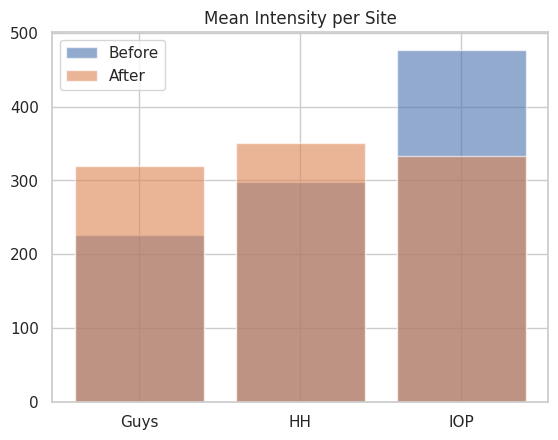

In [ ]:
import numpy as np

mean_before = [combined_data[combined_meta["SITE"] == s].mean() for s in combined_meta["SITE"].unique()]
mean_after = [harmonized_combined[combined_meta["SITE"] == s].mean() for s in combined_meta["SITE"].unique()]

plt.bar(combined_meta["SITE"].unique(), mean_before, alpha=0.6, label="Before")
plt.bar(combined_meta["SITE"].unique(), mean_after, alpha=0.6, label="After")
plt.legend()
plt.title("Mean Intensity per Site")
plt.show()

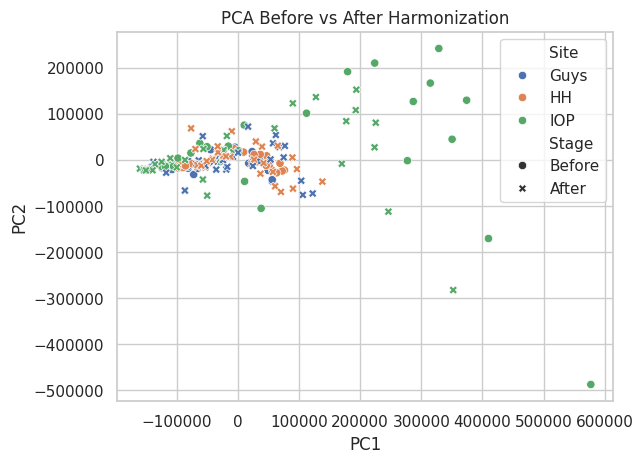

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# PCA before harmonization
pca = PCA(n_components=2)
pca_before = pca.fit_transform(combined_data)
pca_after = pca.fit_transform(harmonized_combined)

df_before = pd.DataFrame({
    "PC1": pca_before[:, 0],
    "PC2": pca_before[:, 1],
    "Site": combined_meta["SITE"],
    "Stage": "Before"
})
df_after = pd.DataFrame({
    "PC1": pca_after[:, 0],
    "PC2": pca_after[:, 1],
    "Site": combined_meta["SITE"],
    "Stage": "After"
})

df = pd.concat([df_before, df_after])

sns.scatterplot(data=df, x="PC1", y="PC2", hue="Site", style="Stage")
plt.title("PCA Before vs After Harmonization")
plt.show()


Applying combat harmonization to images

In [ ]:
rng = np.random.default_rng()
t1_dir = "/content/drive/MyDrive/T1T2Data/Registered/T1"
t2_dir = "/content/drive/MyDrive/T1T2Data/Registered/T2"


t1_files = sorted([f for f in os.listdir(t1_dir) if f.endswith(('.nii', '.nii.gz'))])
t1_full_names=[]
for f in t1_files:
  f_full_name = os.path.join(t1_dir, f)
  t1_full_names.append(f_full_name)

t2_files = sorted([f for f in os.listdir(t2_dir) if f.endswith(('.nii', '.nii.gz'))])
t2_full_names=[]
for f in t2_files:
  f_full_name = os.path.join(t2_dir, f)
  t2_full_names.append(f_full_name)

meta_path = "IXI.xls"
meta_data = pd.read_excel(meta_path)

In [ ]:
ids = [int(f.split('-')[0][-3:]) for f in t1_full_names]
used_patiets_meta = meta_data.loc[meta_data['IXI_ID'].isin(ids)]
used_patiets_meta=used_patiets_meta.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=False, ignore_index=False)
t1_full_names_keep = []
t2_full_names_keep = []
ids_keep = []
for i in ids:
  if i in used_patiets_meta["IXI_ID"].values:
    ids_keep.append(i)

for f in t1_full_names:
  f_id = int(f.split('-')[0][-3:])
  if f_id in ids_keep:
      t1_full_names_keep.append(f)

for f in t2_full_names:
  f_id = int(f.split('-')[0][-3:])
  if f_id in ids_keep:
      t2_full_names_keep.append(f)
locations = [f.split('-')[1] for f in t1_full_names_keep]
used_patiets_meta['SITE'] = locations

In [ ]:
num_indices = 1
guys_indices = [i for i, item in enumerate(locations) if 'Guys' in item][:num_indices]
IOP_indices = [i for i, item in enumerate(locations) if 'IOP' in item][:num_indices]
HH_indices = [i for i, item in enumerate(locations) if 'HH' in item][:num_indices]
representative_indices = guys_indices + IOP_indices + HH_indices
representative_indices.sort()

In [ ]:
t1_rep_full_names=[]
t2_rep_full_names=[]
for i in representative_indices:
  t1_rep_full_names.append(t1_full_names_keep[i])
  t2_rep_full_names.append(t2_full_names_keep[i])

In [ ]:
ref_img = nib.load(t1_rep_full_names[0])

# Resample all to match the reference voxel grid & affine
def resample_to_ref(path, ref_img):
    img = nib.load(path)
    return image.resample_to_img(img, ref_img, interpolation='linear')

t1_imgs = [resample_to_ref(p, ref_img) for p in t1_rep_full_names]
t2_imgs = [resample_to_ref(p, ref_img) for p in t2_rep_full_names]

/tmp/ipython-input-2417647029.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  return image.resample_to_img(img, ref_img, interpolation='linear')
/tmp/ipython-input-2417647029.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return image.resample_to_img(img, ref_img, interpolation='linear')
/tmp/ipython-input-2417647029.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  return image.resample_to_img(img, ref_img, interpolation='linear')
/tmp/ipython-input-2417647029.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to th

In [ ]:
used_patiets_meta=used_patiets_meta.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=False, ignore_index=False)

In [ ]:
# load the mask
mask_path = "mask_subset.npy"
mask_data = np.load(mask_path)
mask_subset = np.load('mask_subset.npy')

In [ ]:
import pickle

with open('combat_model.pkl', 'rb') as f:
    combat_model = pickle.load(f)

In [ ]:
import nibabel as nib
import numpy as np
from tqdm import tqdm

def load_and_mask(imgs, mask_subset):
    vecs = []
    for img in tqdm(imgs):
        data = img.get_fdata()
        vecs.append(data[mask_subset])
    return np.vstack(vecs)

In [ ]:
new_data = load_and_mask(t1_imgs, mask_subset)

100%|██████████| 3/3 [00:00<00:00, 32.28it/s]


In [ ]:
mask_subset.shape

(256, 256, 150)

In [ ]:
rep_ids =[int(f.split('-')[0][-3:]) for f in t1_rep_full_names]
rep_meta_data = used_patiets_meta.loc[used_patiets_meta['IXI_ID'].isin(rep_ids)]

In [ ]:
t1_covars

NameError: name 't1_covars' is not defined

In [ ]:
from neuroHarmonize import harmonizationApply

# Prepare covariates for the T1 images
t1_covars = rep_meta_data[["AGE", "SEX_ID (1=m, 2=f)", "SITE"]].copy()
t1_covars['modality'] = 1

harmonized_new_data = harmonizationApply(new_data, t1_covars, combat_model)


ValueError: operands could not be broadcast together with shapes (100000,3) (99970,1) 

Trying new way to apply harmonization

In [ ]:
# 1. Load and mask both T1 and T2 images
t1_vecs = load_and_mask(t1_imgs, mask_subset)
t2_vecs = load_and_mask(t2_imgs, mask_subset)

# 2. Concatenate T1 and T2 vectors column-wise (axis=1) for each subject
# This creates a data matrix where rows are subjects and columns are
# T1 masked voxels followed by T2 masked voxels.
harmonization_data = np.hstack((t1_vecs, t2_vecs))

# Verify the shape: (Number of Subjects, 2 * Number of Masked Voxels)
print(harmonization_data.shape)

100%|██████████| 3/3 [00:00<00:00, 27.92it/s]

(3, 200000)


In [ ]:
# The number of rows in this must match the number of subjects (rows) in harmonization_data
t1_covars # This matrix will now correctly represent the metadata for all subjects

,AGE,"SEX_ID (1=m, 2=f)",SITE,modality
1,35.800137,2,Guys,1
2,38.781656,1,HH,1
23,37.144422,2,IOP,1


In [ ]:
from neuroHarmonize import harmonizationApply

# Use the combined data matrix
harmonized_new_data = harmonizationApply(harmonization_data, t1_covars, combat_model)

ValueError: operands could not be broadcast together with shapes (200000,3) (99970,1) 